In [1]:
import torch
from torch_geometric.nn import HeteroConv, GENConv
from torch_geometric.transforms import RandomLinkSplit
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle
import os

In [2]:
device = torch.device("cuda")
print(f"Using device: {device}")

Using device: cuda


In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, metadata, hidden_dim, out_dim, edge_attr_dim):
        super().__init__()
        self.conv1 = HeteroConv(
            {
                edge_type: GENConv(
                    in_channels=(-1, -1),
                    out_channels=hidden_dim,
                    edge_dim=edge_attr_dim,
                    learn_t=True,
                )
                for edge_type in metadata[1]
            },
            aggr="sum",
        )
        self.conv2 = HeteroConv(
            {
                edge_type: GENConv(
                    in_channels=(-1, -1),
                    out_channels=out_dim,
                    edge_dim=edge_attr_dim,
                    learn_t=True,
                )
                for edge_type in metadata[1]
            },
            aggr="sum",
        )

    def forward(self, x_dict, edge_index_dict, edge_attr_dict):
        x_dict = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        x_dict = {k: v.relu() for k, v in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict, edge_attr_dict)
        return x_dict

In [5]:
class MultiTypeEdgePredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, edge_attr_dim, num_edge_types):
        super().__init__()
        self.edge_attr_dim = edge_attr_dim
        self.num_edge_types = num_edge_types

        input_dim = in_channels + edge_attr_dim

        # Shared layers: feature extraction
        self.shared_layers = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(hidden_channels, hidden_channels // 2),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
        )

        # Binary classifier: does an edge exist?
        self.edge_existence_head = torch.nn.Linear(hidden_channels // 2, 1)

        # Multi-class classifier: what type of edge?
        self.edge_type_head = torch.nn.Linear(hidden_channels // 2, num_edge_types)

    def forward(self, src_emb, dst_emb, edge_attr=None):
        x = torch.cat([src_emb, dst_emb], dim=-1)

        if edge_attr is not None and self.edge_attr_dim is not None:
            if edge_attr.dim() == 1:
                edge_attr = edge_attr.unsqueeze(-1)
            x = torch.cat([x, edge_attr], dim=-1)

        shared_features = self.shared_layers(x)
        edge_existence_logits = self.edge_existence_head(shared_features).squeeze(-1)
        edge_type_logits = self.edge_type_head(shared_features)
        return edge_existence_logits, edge_type_logits

In [6]:
graph_path_name = "graph_biobert_50_dim_hetero"
graph_data = torch.load(f"../graphs/{graph_path_name}.pt", weights_only=False)

edge_attr_dim = list(graph_data.edge_attr_dict.values())[0].shape[1]
metadata = graph_data.metadata()

In [7]:
def get_edge_attributes(data, edge_type, edge_index, device):
    """
    Get edge attributes for given edge indices. For edges that don't exist in the original graph,
    use mean edge attributes or learnable embeddings.
    """
    if edge_index.shape[1] == 0:
        edge_attr_dim = data[edge_type].edge_attr.shape[1]
        return torch.empty(0, edge_attr_dim, device=device)

    original_edge_index = data[edge_type].edge_index
    original_edge_attr = data[edge_type].edge_attr

    edge_to_attr = {}
    for i in range(original_edge_index.shape[1]):
        src, dst = original_edge_index[0, i].item(), original_edge_index[1, i].item()
        edge_to_attr[(src, dst)] = original_edge_attr[i]

    edge_attrs = []
    mean_attr = original_edge_attr.mean(dim=0)

    for i in range(edge_index.shape[1]):
        src, dst = edge_index[0, i].item(), edge_index[1, i].item()
        if (src, dst) in edge_to_attr:
            edge_attrs.append(edge_to_attr[(src, dst)])
        else:
            edge_attrs.append(mean_attr)

    return torch.stack(edge_attrs).to(device)


def prepare_multi_type_training_data(
    data, edge_types, device, max_samples_per_type=1000
):
    """
    Prepare training data from all edge types for multi-task learning.
    """
    all_pos_edges = []
    all_neg_edges = []
    all_pos_edge_attrs = []
    all_neg_edge_attrs = []
    all_pos_edge_type_labels = []
    all_neg_edge_type_labels = []
    all_pos_node_pairs = []
    all_neg_node_pairs = []

    edge_type_to_idx = {edge_type: idx for idx, edge_type in enumerate(edge_types)}

    for edge_type_idx, edge_type in enumerate(edge_types):
        if not hasattr(data[edge_type], "edge_label_index"):
            continue

        edge_label_index = data[edge_type].edge_label_index
        edge_labels = data[edge_type].edge_label

        pos_mask = edge_labels == 1
        neg_mask = edge_labels == 0

        pos_edge_index = edge_label_index[:, pos_mask]
        neg_edge_index = edge_label_index[:, neg_mask]

        if pos_edge_index.shape[1] == 0 or neg_edge_index.shape[1] == 0:
            continue

        if pos_edge_index.shape[1] > max_samples_per_type:
            indices = torch.randperm(pos_edge_index.shape[1])[:max_samples_per_type]
            pos_edge_index = pos_edge_index[:, indices]

        if neg_edge_index.shape[1] > max_samples_per_type:
            indices = torch.randperm(neg_edge_index.shape[1])[:max_samples_per_type]
            neg_edge_index = neg_edge_index[:, indices]

        pos_edge_attrs = get_edge_attributes(data, edge_type, pos_edge_index, device)
        neg_edge_attrs = get_edge_attributes(data, edge_type, neg_edge_index, device)

        all_pos_node_pairs.append(pos_edge_index)
        all_neg_node_pairs.append(neg_edge_index)
        all_pos_edge_attrs.append(pos_edge_attrs)
        all_neg_edge_attrs.append(neg_edge_attrs)

        pos_edge_type_labels = torch.full(
            (pos_edge_index.shape[1],), edge_type_idx, dtype=torch.long
        )
        neg_edge_type_labels = torch.full(
            (neg_edge_index.shape[1],), edge_type_idx, dtype=torch.long
        )

        all_pos_edge_type_labels.append(pos_edge_type_labels)
        all_neg_edge_type_labels.append(neg_edge_type_labels)

        all_pos_edges.append((edge_type, pos_edge_index))
        all_neg_edges.append((edge_type, neg_edge_index))

    return {
        "pos_edges": all_pos_edges,
        "neg_edges": all_neg_edges,
        "pos_node_pairs": all_pos_node_pairs,
        "neg_node_pairs": all_neg_node_pairs,
        "pos_edge_attrs": all_pos_edge_attrs,
        "neg_edge_attrs": all_neg_edge_attrs,
        "pos_edge_type_labels": all_pos_edge_type_labels,
        "neg_edge_type_labels": all_neg_edge_type_labels,
        "edge_type_to_idx": edge_type_to_idx,
    }

In [8]:
splitter = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    is_undirected=False,
    add_negative_train_samples=True,
    edge_types=graph_data.edge_types,
    rev_edge_types=None,
)

train_data, val_data, test_data = splitter(graph_data)

In [9]:
hidden_dim = 256
out_dim = 50
patience = 5

edge_types = graph_data.edge_types
num_edge_types = len(edge_types)
edge_type_to_idx = {edge_type: idx for idx, edge_type in enumerate(edge_types)}

model = HeteroGNN(
    metadata=metadata,
    hidden_dim=hidden_dim,
    out_dim=out_dim,
    edge_attr_dim=edge_attr_dim,
).to(device)

predictor = MultiTypeEdgePredictor(
    in_channels=out_dim * 2,
    hidden_channels=64,
    edge_attr_dim=edge_attr_dim,
    num_edge_types=num_edge_types,
).to(device)

In [10]:
def evaluate_multi_type_model(
    model, predictor, data, edge_types, edge_type_to_idx, device
):
    model.eval()

    all_existence_preds = []
    all_existence_true = []
    all_type_preds = []
    all_type_true = []

    edge_type_results = {}

    with torch.no_grad():
        x_dict = {k: v.to(device) for k, v in data.x_dict.items()}
        edge_index_dict = {k: v.to(device) for k, v in data.edge_index_dict.items()}
        edge_attr_dict = {k: v.to(device) for k, v in data.edge_attr_dict.items()}
        out = model(x_dict, edge_index_dict, edge_attr_dict)

        for edge_type in edge_types:
            if not hasattr(data[edge_type], "edge_label_index"):
                continue

            edge_label_index = data[edge_type].edge_label_index.to(device)
            edge_labels = data[edge_type].edge_label.to(device)

            if len(edge_labels) == 0:
                edge_type_results[edge_type] = {
                    "existence_auc": 0.0,
                    "existence_acc": 0.0,
                    "type_acc": 0.0,
                    "num_samples": 0,
                    "num_positive": 0,
                }
                continue

            src_embeddings = out[edge_type[0]][edge_label_index[0]]
            dst_embeddings = out[edge_type[2]][edge_label_index[1]]

            edge_attrs = get_edge_attributes(data, edge_type, edge_label_index, device)

            existence_logits, type_logits = predictor(
                src_embeddings, dst_embeddings, edge_attrs
            )
            existence_probs = torch.sigmoid(existence_logits).cpu().numpy()
            type_preds = torch.argmax(type_logits, dim=1).cpu().numpy()

            existence_true = edge_labels.cpu().numpy()
            type_true = torch.full(
                (len(existence_true),), edge_type_to_idx[edge_type]
            ).numpy()

            all_existence_preds.extend(existence_probs)
            all_existence_true.extend(existence_true)
            all_type_preds.extend(type_preds)
            all_type_true.extend(type_true)

            unique_labels = np.unique(existence_true)
            if len(unique_labels) > 1:
                existence_auc = roc_auc_score(existence_true, existence_probs)
            else:
                existence_auc = 0.0

            existence_acc = accuracy_score(existence_true, existence_probs > 0.5)

            pos_mask = existence_true == 1
            if pos_mask.sum() > 0:
                type_acc = accuracy_score(type_true[pos_mask], type_preds[pos_mask])
            else:
                type_acc = 0.0

            edge_type_results[edge_type] = {
                "existence_auc": existence_auc,
                "existence_acc": existence_acc,
                "type_acc": type_acc,
                "num_samples": len(existence_true),
                "num_positive": pos_mask.sum(),
            }

    if len(all_existence_true) > 0:
        unique_labels = np.unique(all_existence_true)
        if len(unique_labels) > 1:
            overall_existence_auc = roc_auc_score(
                all_existence_true, all_existence_preds
            )
        else:
            overall_existence_auc = 0.0
        overall_existence_acc = accuracy_score(
            all_existence_true, np.array(all_existence_preds) > 0.5
        )
        overall_type_acc = accuracy_score(all_type_true, all_type_preds)
    else:
        overall_existence_auc = 0.0
        overall_existence_acc = 0.0
        overall_type_acc = 0.0

    return {
        "overall_existence_auc": overall_existence_auc,
        "overall_existence_acc": overall_existence_acc,
        "overall_type_acc": overall_type_acc,
        "edge_type_results": edge_type_results,
    }

In [11]:
training_data = prepare_multi_type_training_data(
    train_data, edge_types, device, max_samples_per_type=2000
)

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(predictor.parameters()), lr=0.005
)

best_val_acc = 0.0
patience_counter = 0
patience = 15
train_losses = []
val_accuracies = []

for epoch in range(1, 101):
    model.train()
    predictor.train()
    optimizer.zero_grad()

    x_dict = {k: v.to(device) for k, v in train_data.x_dict.items()}
    edge_index_dict = {k: v.to(device) for k, v in train_data.edge_index_dict.items()}
    edge_attr_dict = {k: v.to(device) for k, v in train_data.edge_attr_dict.items()}
    out = model(x_dict, edge_index_dict, edge_attr_dict)

    epoch_existence_loss = 0
    epoch_type_loss = 0

    for i, edge_type in enumerate(edge_types):
        if i >= len(training_data["pos_edges"]):
            continue

        _, pos_edge_index = training_data["pos_edges"][i]
        pos_edge_attrs = training_data["pos_edge_attrs"][i]
        pos_edge_type_labels = training_data["pos_edge_type_labels"][i].to(device)

        _, neg_edge_index = training_data["neg_edges"][i]
        neg_edge_attrs = training_data["neg_edge_attrs"][i]

        if len(pos_edge_index[0]) == 0 or len(neg_edge_index[0]) == 0:
            continue

        src_emb_pos = out[edge_type[0]][pos_edge_index[0]]
        dst_emb_pos = out[edge_type[2]][pos_edge_index[1]]
        src_emb_neg = out[edge_type[0]][neg_edge_index[0]]
        dst_emb_neg = out[edge_type[2]][neg_edge_index[1]]

        pos_existence_logits, pos_type_logits = predictor(
            src_emb_pos, dst_emb_pos, pos_edge_attrs
        )
        neg_existence_logits, neg_type_logits = predictor(
            src_emb_neg, dst_emb_neg, neg_edge_attrs
        )

        all_existence_logits = torch.cat([pos_existence_logits, neg_existence_logits])
        existence_labels = torch.cat(
            [
                torch.ones(len(pos_existence_logits), device=device),
                torch.zeros(len(neg_existence_logits), device=device),
            ]
        )

        existence_loss = torch.nn.functional.binary_cross_entropy_with_logits(
            all_existence_logits, existence_labels
        )
        type_loss = torch.nn.functional.cross_entropy(
            pos_type_logits, pos_edge_type_labels
        )
        epoch_existence_loss += existence_loss
        epoch_type_loss += type_loss

    num_valid_types = min(len(training_data["pos_edges"]), len(edge_types))
    if num_valid_types > 0:
        avg_existence_loss = epoch_existence_loss / num_valid_types
        avg_type_loss = epoch_type_loss / num_valid_types
        total_loss = avg_existence_loss + 0.5 * avg_type_loss

        total_loss.backward()
        optimizer.step()
        train_losses.append(total_loss.item())

        val_results = evaluate_multi_type_model(
            model, predictor, val_data, edge_types, edge_type_to_idx, device
        )
        val_acc = val_results["overall_existence_acc"]
        val_accuracies.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            patience_counter = 0
            print(f"New best validation accuracy: {val_acc:.3f} at epoch {epoch}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(
                f"Early stopping at epoch {epoch}: Train Loss = {total_loss.item():.4f} | Val Accuracy = {val_acc:.3f} | Best Val Accuracy = {best_val_acc:.3f}"
            )
            break

        if epoch % 10 == 0 or epoch == 1:
            print(
                f"Epoch {epoch:3d}: Train Loss = {total_loss.item():.4f} | Val Accuracy = {val_acc:.3f} | Best Val Accuracy = {best_val_acc:.3f}"
            )

        model.train()
        predictor.train()

New best validation accuracy: 0.500 at epoch 1
Epoch   1: Train Loss = 2.1718 | Val Accuracy = 0.500 | Best Val Accuracy = 0.500
New best validation accuracy: 0.520 at epoch 2
New best validation accuracy: 0.581 at epoch 3
New best validation accuracy: 0.676 at epoch 4
New best validation accuracy: 0.724 at epoch 5
New best validation accuracy: 0.728 at epoch 6
Epoch  10: Train Loss = 0.6337 | Val Accuracy = 0.693 | Best Val Accuracy = 0.728
New best validation accuracy: 0.731 at epoch 20
Epoch  20: Train Loss = 0.2876 | Val Accuracy = 0.731 | Best Val Accuracy = 0.731
New best validation accuracy: 0.736 at epoch 22
New best validation accuracy: 0.738 at epoch 23
New best validation accuracy: 0.748 at epoch 25
Epoch  30: Train Loss = 0.1561 | Val Accuracy = 0.739 | Best Val Accuracy = 0.748
New best validation accuracy: 0.752 at epoch 34
Epoch  40: Train Loss = 0.1114 | Val Accuracy = 0.736 | Best Val Accuracy = 0.752
Early stopping at epoch 49: Train Loss = 0.1042 | Val Accuracy = 0.7

In [12]:
test_results = evaluate_multi_type_model(
    model, predictor, test_data, edge_types, edge_type_to_idx, device
)

print(f"Overall Edge Existence AUC: {test_results['overall_existence_auc']:.3f}")
print(f"Overall Edge Existence Accuracy: {test_results['overall_existence_acc']:.3f}")
print(f"Overall Edge Type Accuracy: {test_results['overall_type_acc']:.3f}")

Overall Edge Existence AUC: 0.785
Overall Edge Existence Accuracy: 0.706
Overall Edge Type Accuracy: 0.964


In [13]:
graph_data

HeteroData(
  lncRNA={ x=[1333, 50] },
  miRNA={ x=[512, 50] },
  TF={ x=[336, 50] },
  PCG={ x=[1717, 50] },
  circRNA={ x=[7, 50] },
  snoRNA={ x=[3, 50] },
  (lncRNA, regulates, miRNA)={
    edge_index=[2, 1088],
    edge_attr=[1088, 13],
  },
  (lncRNA, regulates, PCG)={
    edge_index=[2, 5029],
    edge_attr=[5029, 13],
  },
  (lncRNA, regulates, TF)={
    edge_index=[2, 1570],
    edge_attr=[1570, 13],
  },
  (PCG, regulates, miRNA)={
    edge_index=[2, 11],
    edge_attr=[11, 13],
  },
  (TF, regulates, lncRNA)={
    edge_index=[2, 303],
    edge_attr=[303, 13],
  },
  (lncRNA, regulates, lncRNA)={
    edge_index=[2, 34],
    edge_attr=[34, 13],
  },
  (miRNA, regulates, lncRNA)={
    edge_index=[2, 82],
    edge_attr=[82, 13],
  },
  (PCG, regulates, PCG)={
    edge_index=[2, 36],
    edge_attr=[36, 13],
  },
  (circRNA, regulates, miRNA)={
    edge_index=[2, 3],
    edge_attr=[3, 13],
  },
  (circRNA, regulates, PCG)={
    edge_index=[2, 9],
    edge_attr=[9, 13],
  },
  (PCG

In [14]:
def validate_predictions_against_ground_truth(
    model,
    predictor,
    data,
    edge_types,
    edge_type_to_idx,
    device,
    num_samples,
    data_split_name,
):
    model.eval()
    predictor.eval()

    with torch.no_grad():
        x_dict = {k: v.to(device) for k, v in data.x_dict.items()}
        edge_index_dict = {k: v.to(device) for k, v in data.edge_index_dict.items()}
        edge_attr_dict = {k: v.to(device) for k, v in data.edge_attr_dict.items()}
        out = model(x_dict, edge_index_dict, edge_attr_dict)

    correct_existence_predictions = 0
    correct_type_predictions = 0
    total_predictions = 0
    positive_correct = 0
    negative_correct = 0
    total_positive = 0
    total_negative = 0

    for edge_type in edge_types:
        if not hasattr(data[edge_type], "edge_label_index") or not hasattr(
            data[edge_type], "edge_label"
        ):
            continue

        edge_label_index = data[edge_type].edge_label_index
        edge_labels = data[edge_type].edge_label

        if edge_label_index.shape[1] == 0:
            continue

        pos_mask = edge_labels == 1
        neg_mask = edge_labels == 0
        pos_edge_index = edge_label_index[:, pos_mask]
        neg_edge_index = edge_label_index[:, neg_mask]

        max_samples_per_type = num_samples // len(edge_types) // 2

        # Sample positive edges
        if pos_edge_index.shape[1] > 0:
            num_pos_to_sample = min(max_samples_per_type, pos_edge_index.shape[1])
            if num_pos_to_sample > 0:
                sampled_pos_indices = torch.randperm(pos_edge_index.shape[1])[
                    :num_pos_to_sample
                ]
                sampled_pos_edges = pos_edge_index[:, sampled_pos_indices]

                for i in range(sampled_pos_edges.shape[1]):
                    src_idx = sampled_pos_edges[0, i].item()
                    dst_idx = sampled_pos_edges[1, i].item()

                    src_emb = out[edge_type[0]][src_idx].unsqueeze(0)
                    dst_emb = out[edge_type[2]][dst_idx].unsqueeze(0)
                    edge_attrs = get_edge_attributes(
                        data, edge_type, sampled_pos_edges[:, i : i + 1], device
                    )

                    with torch.no_grad():
                        existence_logits, type_logits = predictor(
                            src_emb, dst_emb, edge_attrs
                        )
                        existence_prob = torch.sigmoid(existence_logits).item()
                        predicted_type_idx = torch.argmax(type_logits, dim=1).item()
                        predicted_type = edge_types[predicted_type_idx]

                    existence_correct = existence_prob > 0.5
                    type_correct = predicted_type == edge_type

                    if existence_correct:
                        correct_existence_predictions += 1
                        positive_correct += 1
                    if type_correct:
                        correct_type_predictions += 1

                    total_predictions += 1
                    total_positive += 1

        # Sample negative edges
        if neg_edge_index.shape[1] > 0:
            num_neg_to_sample = min(max_samples_per_type, neg_edge_index.shape[1])
            if num_neg_to_sample > 0:
                sampled_neg_indices = torch.randperm(neg_edge_index.shape[1])[
                    :num_neg_to_sample
                ]
                sampled_neg_edges = neg_edge_index[:, sampled_neg_indices]

                for i in range(sampled_neg_edges.shape[1]):
                    src_idx = sampled_neg_edges[0, i].item()
                    dst_idx = sampled_neg_edges[1, i].item()

                    src_emb = out[edge_type[0]][src_idx].unsqueeze(0)
                    dst_emb = out[edge_type[2]][dst_idx].unsqueeze(0)
                    edge_attrs = get_edge_attributes(
                        data, edge_type, sampled_neg_edges[:, i : i + 1], device
                    )

                    with torch.no_grad():
                        existence_logits, _ = predictor(src_emb, dst_emb, edge_attrs)
                        existence_prob = torch.sigmoid(existence_logits).item()

                    existence_correct = existence_prob <= 0.5

                    if existence_correct:
                        correct_existence_predictions += 1
                        negative_correct += 1

                    total_predictions += 1
                    total_negative += 1

    existence_accuracy = (
        correct_existence_predictions / total_predictions
        if total_predictions > 0
        else 0
    )
    type_accuracy = (
        correct_type_predictions / total_positive if total_positive > 0 else 0
    )
    positive_accuracy = positive_correct / total_positive if total_positive > 0 else 0
    negative_accuracy = negative_correct / total_negative if total_negative > 0 else 0

    print(f"Final evaluation on {data_split_name} set:")
    print(f"Overall edge existence accuracy: {existence_accuracy:.3f}")
    print(f"Positive edge accuracy: {positive_accuracy:.3f}")
    print(f"Negative edge accuracy: {negative_accuracy:.3f}")
    print(f"Edge type accuracy: {type_accuracy:.3f}")


test_results = validate_predictions_against_ground_truth(
    model, predictor, test_data, edge_types, edge_type_to_idx, device, 200, "test"
)

Final evaluation on test set:
Overall edge existence accuracy: 0.784
Positive edge accuracy: 0.784
Negative edge accuracy: 0.784
Edge type accuracy: 0.811


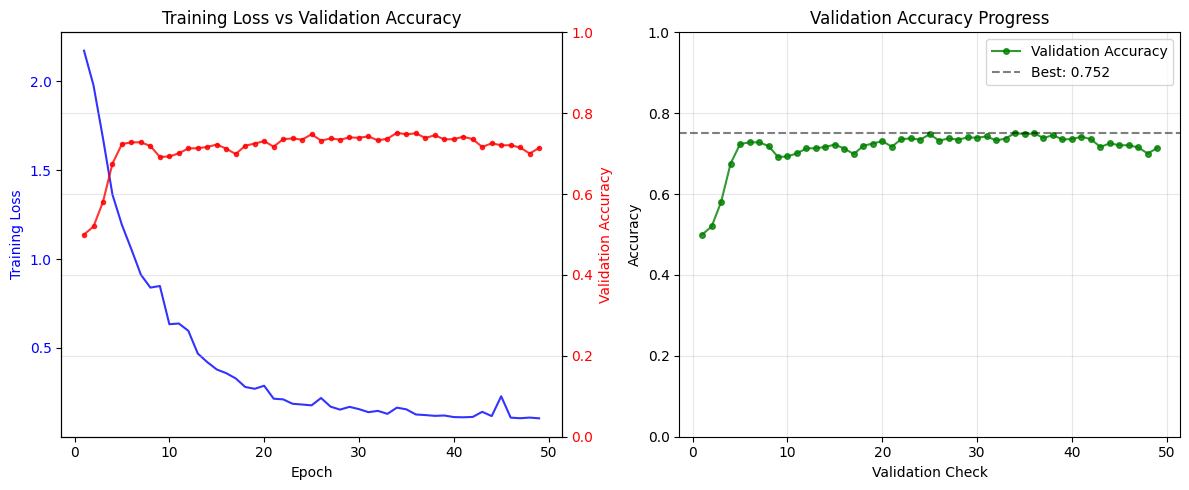

Training Summary:
Total epochs trained: 49
Final training loss: 0.1042
Final validation accuracy: 0.714
Best validation accuracy: 0.752


In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
epochs_range = range(1, len(train_losses) + 1)
val_epochs = range(1, len(val_accuracies) + 1)

ax1 = plt.gca()
line1 = ax1.plot(epochs_range, train_losses, "b-", label="Training Loss", alpha=0.8)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Training Loss", color="b")
ax1.tick_params(axis="y", labelcolor="b")

ax2 = ax1.twinx()
line2 = ax2.plot(
    val_epochs,
    val_accuracies,
    "r-",
    label="Validation Accuracy",
    alpha=0.8,
    marker="o",
    markersize=3,
)
ax2.set_ylabel("Validation Accuracy", color="r")
ax2.tick_params(axis="y", labelcolor="r")
ax2.set_ylim(0, 1)

plt.title("Training Loss vs Validation Accuracy")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(
    val_epochs,
    val_accuracies,
    "g-",
    label="Validation Accuracy",
    alpha=0.8,
    marker="o",
    markersize=4,
)
plt.axhline(
    y=max(val_accuracies),
    color="k",
    linestyle="--",
    alpha=0.5,
    label=f"Best: {max(val_accuracies):.3f}",
)
plt.xlabel("Validation Check")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Progress")
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

print("Training Summary:")
print(f"Total epochs trained: {len(train_losses)}")
print(f"Final training loss: {train_losses[-1]:.4f}")
if val_accuracies:
    print(f"Final validation accuracy: {val_accuracies[-1]:.3f}")
    print(f"Best validation accuracy: {max(val_accuracies):.3f}")

In [16]:
def generate_and_save_node_embeddings(model, graph_data, device, save_path):
    model.eval()

    with torch.no_grad():
        x_dict = {k: v.to(device) for k, v in graph_data.x_dict.items()}
        edge_index_dict = {
            k: v.to(device) for k, v in graph_data.edge_index_dict.items()
        }
        edge_attr_dict = {k: v.to(device) for k, v in graph_data.edge_attr_dict.items()}
        node_embeddings = model(x_dict, edge_index_dict, edge_attr_dict)
        node_embeddings_cpu = {
            node_type: embeddings.cpu().numpy()
            for node_type, embeddings in node_embeddings.items()
        }

    print("Node embeddings created:")
    for node_type, embeddings in node_embeddings_cpu.items():
        print(
            f"  {node_type}: {embeddings.shape[0]} nodes x {embeddings.shape[1]} dimensions"
        )

    with open(save_path, "wb") as f:
        pickle.dump(node_embeddings_cpu, f)

    print(f"Node embeddings saved to: {save_path}")

    return node_embeddings_cpu


embeddings_save_path = "../node_embeddings/node_embeddings_50d.pkl"
node_embeddings = generate_and_save_node_embeddings(
    model=model,
    graph_data=graph_data,
    device=device,
    save_path=embeddings_save_path,
)

Node embeddings created:
  miRNA: 512 nodes x 50 dimensions
  PCG: 1717 nodes x 50 dimensions
  TF: 336 nodes x 50 dimensions
  lncRNA: 1333 nodes x 50 dimensions
  snoRNA: 3 nodes x 50 dimensions
  circRNA: 7 nodes x 50 dimensions
Node embeddings saved to: ../node_embeddings/node_embeddings_50d.pkl


Plotting edge score distributions for training data:
Positive edges - Mean: 0.849, Std: 0.217, Count: 3421
Negative edges - Mean: 0.323, Std: 0.301, Count: 3421
Score ranges - Positive: [0.026851, 1.000000], Negative: [0.000000, 1.000000]


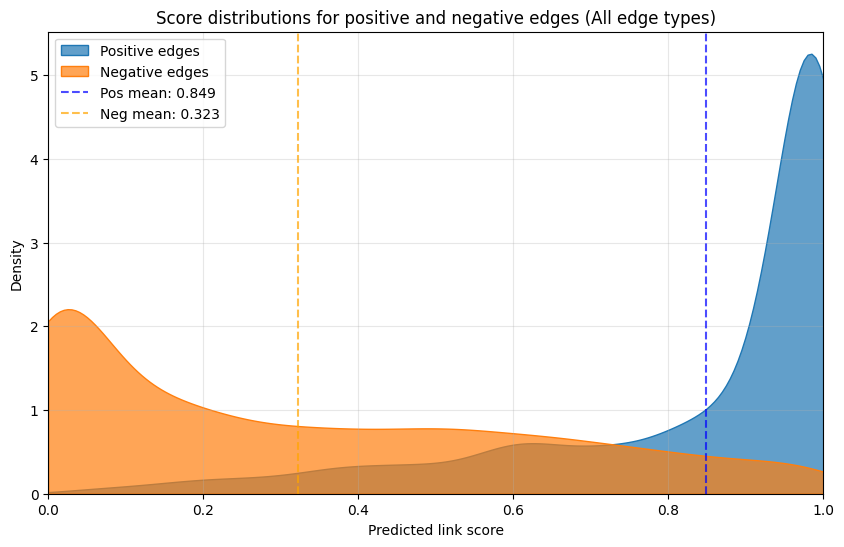


Plotting edge score distributions for test data:
Positive edges - Mean: 0.726, Std: 0.340, Count: 829
Negative edges - Mean: 0.359, Std: 0.278, Count: 829
Score ranges - Positive: [0.000000, 1.000000], Negative: [0.000000, 0.999999]


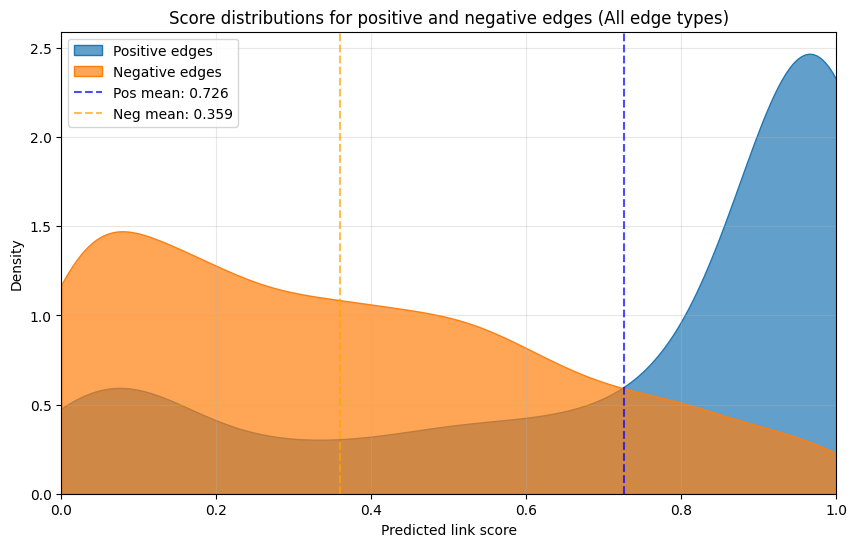


SCORE DISTRIBUTIONS BY EDGE TYPE (TEST DATA)
Saved plot for lncRNA → miRNA to ../plots/score_dist_link_prediction_hetero_gen_50_d_lncRNA_regulates_miRNA.png
Saved plot for lncRNA → PCG to ../plots/score_dist_link_prediction_hetero_gen_50_d_lncRNA_regulates_PCG.png
Saved plot for lncRNA → TF to ../plots/score_dist_link_prediction_hetero_gen_50_d_lncRNA_regulates_TF.png
Saved plot for PCG → miRNA to ../plots/score_dist_link_prediction_hetero_gen_50_d_PCG_regulates_miRNA.png


/tmp/ipykernel_51722/3427443432.py:229: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_51722/3427443432.py:241: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
/tmp/ipykernel_51722/3427443432.py:257: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=8)


Saved plot for TF → lncRNA to ../plots/score_dist_link_prediction_hetero_gen_50_d_TF_regulates_lncRNA.png
Saved plot for lncRNA → lncRNA to ../plots/score_dist_link_prediction_hetero_gen_50_d_lncRNA_regulates_lncRNA.png
Saved plot for miRNA → lncRNA to ../plots/score_dist_link_prediction_hetero_gen_50_d_miRNA_regulates_lncRNA.png
Saved plot for PCG → PCG to ../plots/score_dist_link_prediction_hetero_gen_50_d_PCG_regulates_PCG.png
Saved plot for PCG → lncRNA to ../plots/score_dist_link_prediction_hetero_gen_50_d_PCG_regulates_lncRNA.png


In [17]:
def plot_edge_score_distributions(
    model, predictor, data, edge_types, device, max_samples=1000
):
    """
    Plot score distributions for positive and negative edges across all edge types.
    """
    model.eval()
    predictor.eval()

    all_pos_scores = []
    all_neg_scores = []

    with torch.no_grad():
        x_dict = {k: v.to(device) for k, v in data.x_dict.items()}
        edge_index_dict = {k: v.to(device) for k, v in data.edge_index_dict.items()}
        edge_attr_dict = {k: v.to(device) for k, v in data.edge_attr_dict.items()}
        out = model(x_dict, edge_index_dict, edge_attr_dict)

        for edge_type in edge_types:
            if not hasattr(data[edge_type], "edge_label_index"):
                continue

            edge_label_index = data[edge_type].edge_label_index
            edge_labels = data[edge_type].edge_label

            if edge_label_index.shape[1] == 0:
                continue

            pos_mask = edge_labels == 1
            neg_mask = edge_labels == 0

            pos_edge_index = edge_label_index[:, pos_mask]
            neg_edge_index = edge_label_index[:, neg_mask]

            if pos_edge_index.shape[1] > max_samples:
                indices = torch.randperm(pos_edge_index.shape[1])[:max_samples]
                pos_edge_index = pos_edge_index[:, indices]

            if neg_edge_index.shape[1] > max_samples:
                indices = torch.randperm(neg_edge_index.shape[1])[:max_samples]
                neg_edge_index = neg_edge_index[:, indices]

            if pos_edge_index.shape[1] > 0:
                src_emb_pos = out[edge_type[0]][pos_edge_index[0]]
                dst_emb_pos = out[edge_type[2]][pos_edge_index[1]]
                pos_edge_attrs = get_edge_attributes(
                    data, edge_type, pos_edge_index, device
                )

                pos_existence_logits, _ = predictor(
                    src_emb_pos, dst_emb_pos, pos_edge_attrs
                )
                pos_scores = torch.sigmoid(pos_existence_logits)
                all_pos_scores.extend(pos_scores.cpu().numpy())

            if neg_edge_index.shape[1] > 0:
                src_emb_neg = out[edge_type[0]][neg_edge_index[0]]
                dst_emb_neg = out[edge_type[2]][neg_edge_index[1]]
                neg_edge_attrs = get_edge_attributes(
                    data, edge_type, neg_edge_index, device
                )

                neg_existence_logits, _ = predictor(
                    src_emb_neg, dst_emb_neg, neg_edge_attrs
                )
                neg_scores = torch.sigmoid(neg_existence_logits)
                all_neg_scores.extend(neg_scores.cpu().numpy())

    plt.figure(figsize=(10, 6))

    if len(all_pos_scores) > 0 and len(all_neg_scores) > 0:
        all_pos_scores_clipped = np.clip(all_pos_scores, 0, 1)
        all_neg_scores_clipped = np.clip(all_neg_scores, 0, 1)

        sns.kdeplot(
            all_pos_scores_clipped,
            label="Positive edges",
            fill=True,
            alpha=0.7,
            clip=(0, 1),
        )
        sns.kdeplot(
            all_neg_scores_clipped,
            label="Negative edges",
            fill=True,
            alpha=0.7,
            clip=(0, 1),
        )

        plt.xlabel("Predicted link score")
        plt.ylabel("Density")
        plt.xlim(0, 1)
        plt.legend()
        plt.title(
            "Score distributions for positive and negative edges (All edge types)"
        )
        plt.grid(True, alpha=0.3)

        pos_mean = np.mean(all_pos_scores)
        neg_mean = np.mean(all_neg_scores)
        plt.axvline(
            pos_mean,
            color="blue",
            linestyle="--",
            alpha=0.7,
            label=f"Pos mean: {pos_mean:.3f}",
        )
        plt.axvline(
            neg_mean,
            color="orange",
            linestyle="--",
            alpha=0.7,
            label=f"Neg mean: {neg_mean:.3f}",
        )
        plt.legend()

        print(
            f"Positive edges - Mean: {pos_mean:.3f}, Std: {np.std(all_pos_scores):.3f}, Count: {len(all_pos_scores)}"
        )
        print(
            f"Negative edges - Mean: {neg_mean:.3f}, Std: {np.std(all_neg_scores):.3f}, Count: {len(all_neg_scores)}"
        )

        pos_min, pos_max = np.min(all_pos_scores), np.max(all_pos_scores)
        neg_min, neg_max = np.min(all_neg_scores), np.max(all_neg_scores)
        print(
            f"Score ranges - Positive: [{pos_min:.6f}, {pos_max:.6f}], Negative: [{neg_min:.6f}, {neg_max:.6f}]"
        )
    else:
        plt.text(
            0.5,
            0.5,
            "No data available for plotting",
            ha="center",
            va="center",
            transform=plt.gca().transAxes,
        )
        plt.title("Score distributions - No data available")

    plt.show()


def plot_edge_score_distributions_by_type(
    model, predictor, data, edge_types, device, max_samples=1000, save_dir="../plots"
):
    """
    Plot score distributions for positive and negative edges for each edge type separately,
    and save each plot as a PNG in the specified directory.
    """
    model.eval()
    predictor.eval()

    edge_type_data = {}

    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        x_dict = {k: v.to(device) for k, v in data.x_dict.items()}
        edge_index_dict = {k: v.to(device) for k, v in data.edge_index_dict.items()}
        edge_attr_dict = {k: v.to(device) for k, v in data.edge_attr_dict.items()}
        out = model(x_dict, edge_index_dict, edge_attr_dict)

        for i, edge_type in enumerate(edge_types):
            edge_type_str = f"{edge_type[0]} → {edge_type[2]} ({edge_type[1]})"

            if not hasattr(data[edge_type], "edge_label_index"):
                continue

            edge_label_index = data[edge_type].edge_label_index
            edge_labels = data[edge_type].edge_label

            if edge_label_index.shape[1] == 0:
                continue

            pos_mask = edge_labels == 1
            neg_mask = edge_labels == 0

            pos_edge_index = edge_label_index[:, pos_mask]
            neg_edge_index = edge_label_index[:, neg_mask]

            if pos_edge_index.shape[1] > max_samples:
                indices = torch.randperm(pos_edge_index.shape[1])[:max_samples]
                pos_edge_index = pos_edge_index[:, indices]

            if neg_edge_index.shape[1] > max_samples:
                indices = torch.randperm(neg_edge_index.shape[1])[:max_samples]
                neg_edge_index = neg_edge_index[:, indices]

            pos_scores = []
            neg_scores = []

            if pos_edge_index.shape[1] > 0:
                src_emb_pos = out[edge_type[0]][pos_edge_index[0]]
                dst_emb_pos = out[edge_type[2]][pos_edge_index[1]]
                pos_edge_attrs = get_edge_attributes(
                    data, edge_type, pos_edge_index, device
                )

                pos_existence_logits, _ = predictor(
                    src_emb_pos, dst_emb_pos, pos_edge_attrs
                )
                pos_scores = torch.sigmoid(pos_existence_logits).cpu().numpy()

            if neg_edge_index.shape[1] > 0:
                src_emb_neg = out[edge_type[0]][neg_edge_index[0]]
                dst_emb_neg = out[edge_type[2]][neg_edge_index[1]]
                neg_edge_attrs = get_edge_attributes(
                    data, edge_type, neg_edge_index, device
                )

                neg_existence_logits, _ = predictor(
                    src_emb_neg, dst_emb_neg, neg_edge_attrs
                )
                neg_scores = torch.sigmoid(neg_existence_logits).cpu().numpy()

            if len(pos_scores) > 0 or len(neg_scores) > 0:
                edge_type_data[edge_type] = {
                    "pos_scores": pos_scores,
                    "neg_scores": neg_scores,
                }

    for edge_type, scores_data in edge_type_data.items():
        plt.figure(figsize=(6, 4))
        pos_scores = scores_data["pos_scores"]
        neg_scores = scores_data["neg_scores"]

        if len(pos_scores) > 0:
            pos_scores = np.clip(pos_scores, 0, 1)
            sns.kdeplot(
                pos_scores,
                label="Positive edges",
                fill=True,
                alpha=0.7,
                color="blue",
                clip=(0, 1),
            )
            pos_mean = np.mean(pos_scores)
            plt.axvline(pos_mean, color="blue", linestyle="--", alpha=0.7)
        if len(neg_scores) > 0:
            neg_scores = np.clip(neg_scores, 0, 1)
            sns.kdeplot(
                neg_scores,
                label="Negative edges",
                fill=True,
                alpha=0.7,
                color="orange",
                clip=(0, 1),
            )
            neg_mean = np.mean(neg_scores)
            plt.axvline(neg_mean, color="orange", linestyle="--", alpha=0.7)

        plt.xlim(0, 1)
        edge_type_str = f"{edge_type[0]} → {edge_type[2]}"
        plt.title(f"{edge_type_str}\n({edge_type[1]})", fontsize=10)
        plt.xlabel("Predicted link score")
        plt.ylabel("Density")
        plt.legend(fontsize=8)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        type_name = f"{edge_type[0]}_{edge_type[1]}_{edge_type[2]}"
        filename = f"score_dist_link_prediction_hetero_gen_50_d_{type_name}.png"
        filepath = os.path.join(save_dir, filename)
        plt.savefig(filepath)
        plt.close()
        print(f"Saved plot for {edge_type_str} to {filepath}")


# Plot score distributions for training data
print("Plotting edge score distributions for training data:")
plot_edge_score_distributions(model, predictor, train_data, edge_types, device)

# Plot score distributions for test data
print("\nPlotting edge score distributions for test data:")
plot_edge_score_distributions(model, predictor, test_data, edge_types, device)

# Plot score distributions by edge type for test data and save PNGs
print("\n" + "=" * 60)
print("SCORE DISTRIBUTIONS BY EDGE TYPE (TEST DATA)")
print("=" * 60)
plot_edge_score_distributions_by_type(model, predictor, test_data, edge_types, device)

In [18]:
def get_top_negative_edges_lncRNA_to_TF(model, predictor, data, device, top_k=50):
    """
    Extract the top k negative edges from lncRNA to TF with highest confidence scores.
    """
    model.eval()
    predictor.eval()

    target_edge_type = ("lncRNA", "regulates", "TF")

    # Check if this edge type exists in the data
    if target_edge_type not in data.edge_types:
        print(f"Edge type {target_edge_type} not found in data")
        return None

    # Check if the edge type has labels
    if not hasattr(data[target_edge_type], "edge_label_index") or not hasattr(
        data[target_edge_type], "edge_label"
    ):
        print(f"No labels found for edge type {target_edge_type}")
        return None

    with torch.no_grad():
        # Get node embeddings
        x_dict = {k: v.to(device) for k, v in data.x_dict.items()}
        edge_index_dict = {k: v.to(device) for k, v in data.edge_index_dict.items()}
        edge_attr_dict = {k: v.to(device) for k, v in data.edge_attr_dict.items()}
        out = model(x_dict, edge_index_dict, edge_attr_dict)

        # Get the edge label data for lncRNA to TF
        edge_label_index = data[target_edge_type].edge_label_index.to(device)
        edge_labels = data[target_edge_type].edge_label.to(device)

        # Filter for negative edges only
        neg_mask = edge_labels == 0
        neg_edge_index = edge_label_index[:, neg_mask]

        if neg_edge_index.shape[1] == 0:
            print(f"No negative edges found for {target_edge_type}")
            return None

        print(f"Found {neg_edge_index.shape[1]} negative edges for {target_edge_type}")

        # Get embeddings for negative edges
        src_emb_neg = out[target_edge_type[0]][neg_edge_index[0]]  # lncRNA embeddings
        dst_emb_neg = out[target_edge_type[2]][neg_edge_index[1]]  # TF embeddings

        # Get edge attributes for negative edges
        neg_edge_attrs = get_edge_attributes(
            data, target_edge_type, neg_edge_index, device
        )

        # Get predictions for negative edges
        neg_existence_logits, _ = predictor(src_emb_neg, dst_emb_neg, neg_edge_attrs)
        neg_scores = torch.sigmoid(neg_existence_logits)

        # Get top k highest scoring negative edges
        top_k_actual = min(top_k, len(neg_scores))
        top_scores, top_indices = torch.topk(neg_scores, top_k_actual)

        # Get the corresponding node indices (ensure indices are on the same device)
        top_neg_edges = neg_edge_index[:, top_indices.to(neg_edge_index.device)]

        # Convert to CPU for easier handling
        top_neg_edges_cpu = top_neg_edges.cpu()
        top_scores_cpu = top_scores.cpu()

        # Convert to lists for easier handling
        results = []
        for i in range(top_k_actual):
            lncRNA_idx = top_neg_edges_cpu[0, i].item()
            TF_idx = top_neg_edges_cpu[1, i].item()
            confidence_score = top_scores_cpu[i].item()

            results.append(
                {
                    "lncRNA_idx": lncRNA_idx,
                    "TF_idx": TF_idx,
                    "confidence_score": confidence_score,
                    "rank": i + 1,
                }
            )

        return results


def display_top_negative_edges(results, data=None):
    """
    Display the results in a nice format.
    """
    if results is None:
        print("No results to display")
        return

    print(
        f"\nTop {len(results)} negative lncRNA → TF edges with highest confidence scores:"
    )
    print("=" * 80)
    print(
        f"{'Rank':<6} {'lncRNA_idx':<12} {'TF_idx':<8} {'Confidence':<12} {'Description'}"
    )
    print("-" * 80)

    for result in results:
        rank = result["rank"]
        lncRNA_idx = result["lncRNA_idx"]
        TF_idx = result["TF_idx"]
        confidence = result["confidence_score"]

        description = f"lncRNA[{lncRNA_idx}] → TF[{TF_idx}]"

        print(
            f"{rank:<6} {lncRNA_idx:<12} {TF_idx:<8} {confidence:<12.6f} {description}"
        )

    # Summary statistics
    scores = [r["confidence_score"] for r in results]
    print("\n" + "=" * 80)
    print("Summary Statistics:")
    print(f"  Mean confidence score: {np.mean(scores):.6f}")
    print(f"  Max confidence score:  {np.max(scores):.6f}")
    print(f"  Min confidence score:  {np.min(scores):.6f}")
    print(f"  Std confidence score:  {np.std(scores):.6f}")

    # Count by confidence ranges
    high_conf = sum(1 for s in scores if s > 0.8)
    med_conf = sum(1 for s in scores if 0.5 < s <= 0.8)
    low_conf = sum(1 for s in scores if s <= 0.5)

    print(f"\nConfidence Score Distribution:")
    print(
        f"  High confidence (>0.8):   {high_conf} edges ({high_conf/len(scores)*100:.1f}%)"
    )
    print(
        f"  Medium confidence (0.5-0.8): {med_conf} edges ({med_conf/len(scores)*100:.1f}%)"
    )
    print(
        f"  Low confidence (≤0.5):     {low_conf} edges ({low_conf/len(scores)*100:.1f}%)"
    )


# We'll run this after the model is trained

In [19]:
# Extract top 50 negative edges from lncRNA to TF with highest confidence scores
print("Extracting top 50 negative lncRNA → TF edges with highest confidence scores...")
print("Using test data for analysis...")

top_negative_edges_lncrna_to_tf = get_top_negative_edges_lncRNA_to_TF(
    model=model, predictor=predictor, data=test_data, device=device, top_k=50
)

# Display the results
display_top_negative_edges(top_negative_edges_lncrna_to_tf)

Extracting top 50 negative lncRNA → TF edges with highest confidence scores...
Using test data for analysis...
Found 157 negative edges for ('lncRNA', 'regulates', 'TF')

Top 50 negative lncRNA → TF edges with highest confidence scores:
Rank   lncRNA_idx   TF_idx   Confidence   Description
--------------------------------------------------------------------------------
1      864          38       0.998021     lncRNA[864] → TF[38]
2      607          38       0.995589     lncRNA[607] → TF[38]
3      164          36       0.970491     lncRNA[164] → TF[36]
4      787          225      0.958039     lncRNA[787] → TF[225]
5      1236         323      0.956306     lncRNA[1236] → TF[323]
6      672          8        0.942018     lncRNA[672] → TF[8]
7      1186         52       0.938165     lncRNA[1186] → TF[52]
8      717          80       0.907419     lncRNA[717] → TF[80]
9      941          56       0.904020     lncRNA[941] → TF[56]
10     472          137      0.897980     lncRNA[472] → TF

In [20]:
def get_top_negative_edges_lncRNA_to_PCG(model, predictor, data, device, top_k=50):
    """
    Extract the top k negative edges from lncRNA to PCG with highest confidence scores.
    """
    model.eval()
    predictor.eval()

    target_edge_type = ("lncRNA", "regulates", "PCG")

    # Check if this edge type exists in the data
    if target_edge_type not in data.edge_types:
        print(f"Edge type {target_edge_type} not found in data")
        return None

    # Check if the edge type has labels
    if not hasattr(data[target_edge_type], "edge_label_index") or not hasattr(
        data[target_edge_type], "edge_label"
    ):
        print(f"No labels found for edge type {target_edge_type}")
        return None

    with torch.no_grad():
        # Get node embeddings
        x_dict = {k: v.to(device) for k, v in data.x_dict.items()}
        edge_index_dict = {k: v.to(device) for k, v in data.edge_index_dict.items()}
        edge_attr_dict = {k: v.to(device) for k, v in data.edge_attr_dict.items()}
        out = model(x_dict, edge_index_dict, edge_attr_dict)

        # Get the edge label data for lncRNA to PCG
        edge_label_index = data[target_edge_type].edge_label_index.to(device)
        edge_labels = data[target_edge_type].edge_label.to(device)

        # Filter for negative edges only
        neg_mask = edge_labels == 0
        neg_edge_index = edge_label_index[:, neg_mask]

        if neg_edge_index.shape[1] == 0:
            print(f"No negative edges found for {target_edge_type}")
            return None

        print(f"Found {neg_edge_index.shape[1]} negative edges for {target_edge_type}")

        # Get embeddings for negative edges
        src_emb_neg = out[target_edge_type[0]][neg_edge_index[0]]  # lncRNA embeddings
        dst_emb_neg = out[target_edge_type[2]][neg_edge_index[1]]  # PCG embeddings

        # Get edge attributes for negative edges
        neg_edge_attrs = get_edge_attributes(
            data, target_edge_type, neg_edge_index, device
        )

        # Get predictions for negative edges
        neg_existence_logits, _ = predictor(src_emb_neg, dst_emb_neg, neg_edge_attrs)
        neg_scores = torch.sigmoid(neg_existence_logits)

        # Get top k highest scoring negative edges
        top_k_actual = min(top_k, len(neg_scores))
        top_scores, top_indices = torch.topk(neg_scores, top_k_actual)

        # Get the corresponding node indices (ensure indices are on the same device)
        top_neg_edges = neg_edge_index[:, top_indices.to(neg_edge_index.device)]

        # Convert to CPU for easier handling
        top_neg_edges_cpu = top_neg_edges.cpu()
        top_scores_cpu = top_scores.cpu()

        # Convert to lists for easier handling
        results = []
        for i in range(top_k_actual):
            lncRNA_idx = top_neg_edges_cpu[0, i].item()
            PCG_idx = top_neg_edges_cpu[1, i].item()
            confidence_score = top_scores_cpu[i].item()

            results.append(
                {
                    "lncRNA_idx": lncRNA_idx,
                    "PCG_idx": PCG_idx,
                    "confidence_score": confidence_score,
                    "rank": i + 1,
                }
            )

        return results


def display_top_negative_edges(results, data=None):
    """
    Display the results in a nice format.
    """
    if results is None:
        print("No results to display")
        return

    print(
        f"\nTop {len(results)} negative lncRNA → PCG edges with highest confidence scores:"
    )
    print("=" * 80)
    print(
        f"{'Rank':<6} {'lncRNA_idx':<12} {'PCG_idx':<8} {'Confidence':<12} {'Description'}"
    )
    print("-" * 80)

    for result in results:
        rank = result["rank"]
        lncRNA_idx = result["lncRNA_idx"]
        PCG_idx = result["PCG_idx"]
        confidence = result["confidence_score"]

        description = f"lncRNA[{lncRNA_idx}] → PCG[{PCG_idx}]"

        print(
            f"{rank:<6} {lncRNA_idx:<12} {PCG_idx:<8} {confidence:<12.6f} {description}"
        )

In [21]:
top_negative_edges_lncrna_to_pcg = get_top_negative_edges_lncRNA_to_PCG(
    model=model, predictor=predictor, data=test_data, device=device, top_k=50
)
display_top_negative_edges(top_negative_edges_lncrna_to_pcg)

Found 502 negative edges for ('lncRNA', 'regulates', 'PCG')

Top 50 negative lncRNA → PCG edges with highest confidence scores:
Rank   lncRNA_idx   PCG_idx  Confidence   Description
--------------------------------------------------------------------------------
1      19           1675     0.999281     lncRNA[19] → PCG[1675]
2      843          168      0.999260     lncRNA[843] → PCG[168]
3      683          522      0.997872     lncRNA[683] → PCG[522]
4      1303         318      0.986015     lncRNA[1303] → PCG[318]
5      268          779      0.985322     lncRNA[268] → PCG[779]
6      118          1481     0.965591     lncRNA[118] → PCG[1481]
7      901          308      0.948427     lncRNA[901] → PCG[308]
8      709          514      0.948324     lncRNA[709] → PCG[514]
9      339          428      0.930075     lncRNA[339] → PCG[428]
10     56           1056     0.929384     lncRNA[56] → PCG[1056]
11     905          273      0.919927     lncRNA[905] → PCG[273]
12     852          

In [22]:
from collections import Counter

homogeneous_data = torch.load(f"../graphs/graph_biobert_50_dim.pt", weights_only=False)
node_type_names = ["miRNA", "PCG", "TF", "lncRNA", "snoRNA", "circRNA"]
node_type_ids = torch.argmax(homogeneous_data.x[:, -7:], dim=1)
node_types = [node_type_names[i] for i in node_type_ids.tolist()]
node_type_counts = Counter(node_types)


def get_node_name_by_type_index(type, index_in_type):
    type_to_index = {
        "PCG": 1,
        "TF": 2,
        "lncRNA": 3,
    }
    indices = (node_type_ids == type_to_index[type]).nonzero(as_tuple=True)[0]
    index = indices[index_in_type].item()
    for node, idx in homogeneous_data.node_to_idx.items():
        if idx == index:
            return node


top_negative_edges_lncrna_to_pcg_above_confidence_score = [
    entry
    for entry in top_negative_edges_lncrna_to_pcg
    if entry["confidence_score"] > 0.8
]
top_negative_edges_lncrna_to_tf_above_confidence_score = [
    entry
    for entry in top_negative_edges_lncrna_to_tf
    if entry["confidence_score"] > 0.8
]

top_neg_edges = []

for entry in top_negative_edges_lncrna_to_pcg_above_confidence_score:
    lncrna_name = get_node_name_by_type_index("lncRNA", entry["lncRNA_idx"])
    pcg_name = get_node_name_by_type_index("PCG", entry["PCG_idx"])
    edge = {
        "src": lncrna_name,
        "trg": pcg_name,
        "confidence_score": entry["confidence_score"],
    }
    top_neg_edges.append(edge)

for entry in top_negative_edges_lncrna_to_tf_above_confidence_score:
    lncrna_name = get_node_name_by_type_index("lncRNA", entry["lncRNA_idx"])
    tf_name = get_node_name_by_type_index("TF", entry["TF_idx"])
    edge = {
        "src": lncrna_name,
        "trg": tf_name,
        "confidence_score": entry["confidence_score"],
    }
    top_neg_edges.append(edge)

print(top_neg_edges)

[{'src': 'TALAM1', 'trg': 'PI3K', 'confidence_score': 0.9992814660072327}, {'src': 'LINC01198', 'trg': 'CCNE1', 'confidence_score': 0.9992596507072449}, {'src': 'LINC01518', 'trg': 'BCL2', 'confidence_score': 0.9978722333908081}, {'src': 'LUCAT1', 'trg': 'CDK6', 'confidence_score': 0.9860153198242188}, {'src': 'NKILA', 'trg': 'NOS3', 'confidence_score': 0.9853222370147705}, {'src': 'CCR5AS', 'trg': 'CTNNB1', 'confidence_score': 0.9655909538269043}, {'src': 'HOTTIP', 'trg': 'ESM1', 'confidence_score': 0.9484273195266724}, {'src': 'NLUCAT1', 'trg': 'CDCA4', 'confidence_score': 0.9483237266540527}, {'src': 'HIF1A-AS1', 'trg': 'FGFR1', 'confidence_score': 0.93007493019104}, {'src': 'LINC01278', 'trg': 'MMP3', 'confidence_score': 0.9293839335441589}, {'src': 'LEF-AS1', 'trg': 'PTBP1', 'confidence_score': 0.9199265837669373}, {'src': 'snaR', 'trg': 'IL24', 'confidence_score': 0.9178842902183533}, {'src': 'NLUCAT1', 'trg': 'SELL', 'confidence_score': 0.9041486382484436}, {'src': 'WFDC21P', 't

In [23]:
node_embeddings["lncRNA"]

dict_node_embeddings = []
for idx in range(len(node_embeddings["lncRNA"])):
    node_embeddings_entry = {
        "name": get_node_name_by_type_index("lncRNA", idx),
        "embedding": node_embeddings["lncRNA"][idx].tolist(),
    }
    dict_node_embeddings.append(node_embeddings_entry)


with open("../node_embeddings/node_embeddings_50d_dict.pkl", "wb") as f:
    pickle.dump(dict_node_embeddings, f)

In [24]:
import pandas as pd

df_valid = pd.read_csv(
    "../data/datasets/lncRNA_interactionascsv.csv",
    sep=",",
    skiprows=1,
    low_memory=False,
)

In [25]:
def validate_predictions(
    df_valid: pd.DataFrame,
    lncrna_col: str = "firstName",
    target_col: str = "secondName",
) -> None:
    """Validate predictions against known interactions database"""
    try:
        known_interactions = set(
            zip(df_valid[lncrna_col].str.upper(), df_valid[target_col].str.upper())
        )
        print(f"\nValidation against {len(known_interactions)} known interactions:")
        print("=" * 60)
        validated_count = 0
        for i in range(len(top_neg_edges)):
            src = top_neg_edges[i]["src"].upper()
            tgt = top_neg_edges[i]["trg"].upper()
            is_known = (src, tgt) in known_interactions or (
                tgt,
                src,
            ) in known_interactions
            if is_known:
                validated_count += 1
            print(
                f"{src} :left_right_arrow: {tgt} | score: {top_neg_edges[i]['confidence_score']:.4f} | validated: {is_known}"
            )
        print(
            f"\nValidation rate: {validated_count}/{len(top_neg_edges)} ({validated_count/len(top_neg_edges)*100:.1f}%)"
        )
    except Exception as e:
        print(f"Could not validate predictions: {e}")

In [29]:
graph_data

HeteroData(
  lncRNA={ x=[1333, 50] },
  miRNA={ x=[512, 50] },
  TF={ x=[336, 50] },
  PCG={ x=[1717, 50] },
  circRNA={ x=[7, 50] },
  snoRNA={ x=[3, 50] },
  (lncRNA, regulates, miRNA)={
    edge_index=[2, 1088],
    edge_attr=[1088, 13],
  },
  (lncRNA, regulates, PCG)={
    edge_index=[2, 5029],
    edge_attr=[5029, 13],
  },
  (lncRNA, regulates, TF)={
    edge_index=[2, 1570],
    edge_attr=[1570, 13],
  },
  (PCG, regulates, miRNA)={
    edge_index=[2, 11],
    edge_attr=[11, 13],
  },
  (TF, regulates, lncRNA)={
    edge_index=[2, 303],
    edge_attr=[303, 13],
  },
  (lncRNA, regulates, lncRNA)={
    edge_index=[2, 34],
    edge_attr=[34, 13],
  },
  (miRNA, regulates, lncRNA)={
    edge_index=[2, 82],
    edge_attr=[82, 13],
  },
  (PCG, regulates, PCG)={
    edge_index=[2, 36],
    edge_attr=[36, 13],
  },
  (circRNA, regulates, miRNA)={
    edge_index=[2, 3],
    edge_attr=[3, 13],
  },
  (circRNA, regulates, PCG)={
    edge_index=[2, 9],
    edge_attr=[9, 13],
  },
  (PCG

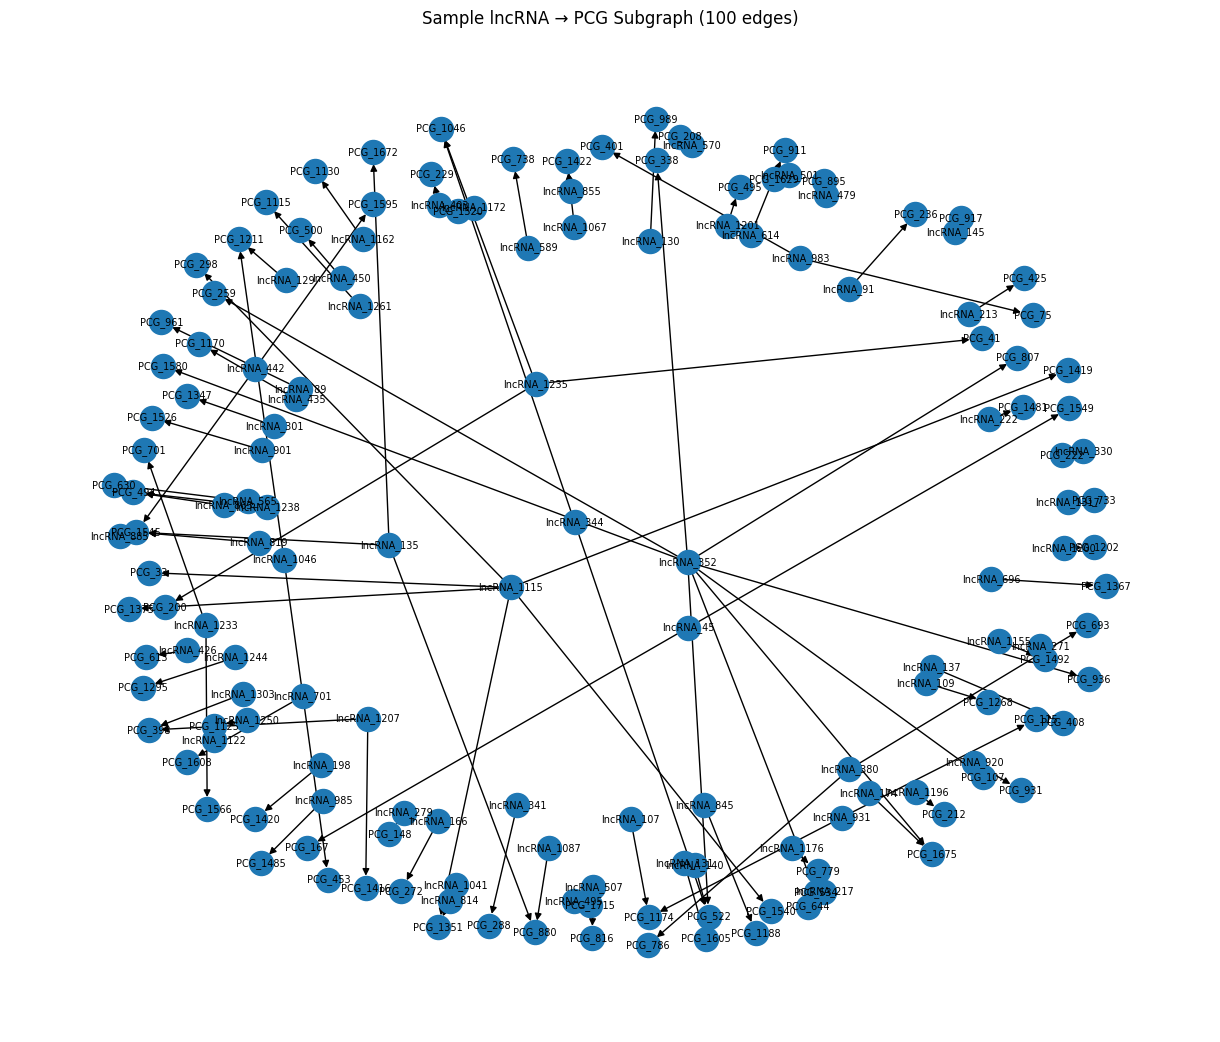

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

edge_type = ("lncRNA", "regulates", "PCG")
num_edges = 100  # Increase this number for more connections
edge_index = train_data[edge_type].edge_index[:, :num_edges]

G = nx.DiGraph()
for i in range(edge_index.shape[1]):
    src = edge_index[0, i].item()
    dst = edge_index[1, i].item()
    G.add_edge(f"lncRNA_{src}", f"PCG_{dst}")

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=300, font_size=7, arrows=True)
plt.title(f"Sample lncRNA → PCG Subgraph ({num_edges} edges)")
plt.show()

In [26]:
validate_predictions(df_valid)


Validation against 779410 known interactions:
TALAM1 :left_right_arrow: PI3K | score: 0.9993 | validated: False
LINC01198 :left_right_arrow: CCNE1 | score: 0.9993 | validated: False
LINC01518 :left_right_arrow: BCL2 | score: 0.9979 | validated: False
LUCAT1 :left_right_arrow: CDK6 | score: 0.9860 | validated: False
NKILA :left_right_arrow: NOS3 | score: 0.9853 | validated: False
CCR5AS :left_right_arrow: CTNNB1 | score: 0.9656 | validated: False
HOTTIP :left_right_arrow: ESM1 | score: 0.9484 | validated: False
NLUCAT1 :left_right_arrow: CDCA4 | score: 0.9483 | validated: False
HIF1A-AS1 :left_right_arrow: FGFR1 | score: 0.9301 | validated: False
LINC01278 :left_right_arrow: MMP3 | score: 0.9294 | validated: False
LEF-AS1 :left_right_arrow: PTBP1 | score: 0.9199 | validated: False
SNAR :left_right_arrow: IL24 | score: 0.9179 | validated: False
NLUCAT1 :left_right_arrow: SELL | score: 0.9041 | validated: False
WFDC21P :left_right_arrow: AGPAT2 | score: 0.8986 | validated: False
POU3F3 :

In [ ]:
# Create visualizations for the high-confidence negative edges
plt.figure(figsize=(15, 10))

# Plot 1: Confidence score distribution
plt.subplot(2, 3, 1)
confidence_scores = [result["confidence_score"] for result in top_negative_edges]
plt.hist(confidence_scores, bins=20, alpha=0.7, color="orange", edgecolor="black")
plt.axvline(
    np.mean(confidence_scores),
    color="red",
    linestyle="--",
    label=f"Mean: {np.mean(confidence_scores):.3f}",
)
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.title("Distribution of Top 50 Negative Edge\nConfidence Scores")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: lncRNA node distribution
plt.subplot(2, 3, 2)
lncRNA_indices = [result["lncRNA_idx"] for result in top_negative_edges]
plt.hist(lncRNA_indices, bins=20, alpha=0.7, color="blue", edgecolor="black")
plt.xlabel("lncRNA Node Index")
plt.ylabel("Frequency")
plt.title("Distribution of lncRNA Nodes\nin Top Negative Edges")
plt.grid(True, alpha=0.3)

# Plot 3: TF node distribution
plt.subplot(2, 3, 3)
TF_indices = [result["TF_idx"] for result in top_negative_edges]
plt.hist(TF_indices, bins=20, alpha=0.7, color="green", edgecolor="black")
plt.xlabel("TF Node Index")
plt.ylabel("Frequency")
plt.title("Distribution of TF Nodes\nin Top Negative Edges")
plt.grid(True, alpha=0.3)

# Plot 4: Rank vs Confidence Score
plt.subplot(2, 3, 4)
ranks = [result["rank"] for result in top_negative_edges]
plt.plot(ranks, confidence_scores, "o-", alpha=0.7, color="purple")
plt.xlabel("Rank")
plt.ylabel("Confidence Score")
plt.title("Confidence Score by Rank")
plt.grid(True, alpha=0.3)

# Plot 5: Node degree analysis (count how many times each node appears)
plt.subplot(2, 3, 5)
from collections import Counter

lncRNA_counts = Counter(lncRNA_indices)
TF_counts = Counter(TF_indices)

# Get the most frequent nodes
top_lncRNAs = lncRNA_counts.most_common(10)
top_TFs = TF_counts.most_common(10)

x_pos = np.arange(len(top_lncRNAs))
lncRNA_freq = [count for _, count in top_lncRNAs]
plt.bar(x_pos, lncRNA_freq, alpha=0.7, color="blue")
plt.xlabel("Top lncRNA Nodes")
plt.ylabel("Frequency in Top 50")
plt.title("Most Frequent lncRNA Nodes\nin High-Conf Negative Edges")
plt.xticks(x_pos, [f"lnc{idx}" for idx, _ in top_lncRNAs], rotation=45)
plt.grid(True, alpha=0.3)

# Plot 6: TF frequency
plt.subplot(2, 3, 6)
x_pos = np.arange(len(top_TFs))
TF_freq = [count for _, count in top_TFs]
plt.bar(x_pos, TF_freq, alpha=0.7, color="green")
plt.xlabel("Top TF Nodes")
plt.ylabel("Frequency in Top 50")
plt.title("Most Frequent TF Nodes\nin High-Conf Negative Edges")
plt.xticks(x_pos, [f"TF{idx}" for idx, _ in top_TFs], rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n" + "=" * 80)
print("DETAILED ANALYSIS OF TOP 50 HIGH-CONFIDENCE NEGATIVE lncRNA → TF EDGES")
print("=" * 80)

print(f"\n1. CONFIDENCE SCORE STATISTICS:")
print(f"   Range: [{min(confidence_scores):.6f}, {max(confidence_scores):.6f}]")
print(
    f"   Quartiles: Q1={np.percentile(confidence_scores, 25):.6f}, "
    f"Q2={np.percentile(confidence_scores, 50):.6f}, "
    f"Q3={np.percentile(confidence_scores, 75):.6f}"
)

print(f"\n2. NODE COVERAGE:")
print(
    f"   Unique lncRNA nodes involved: {len(set(lncRNA_indices))} out of {graph_data['lncRNA'].x.shape[0]} total"
)
print(
    f"   Unique TF nodes involved: {len(set(TF_indices))} out of {graph_data['TF'].x.shape[0]} total"
)

print(f"\n3. MOST ACTIVE NODES:")
print(f"   Top 5 lncRNA nodes:")
for i, (node_idx, count) in enumerate(top_lncRNAs[:5]):
    print(
        f"     {i+1}. lncRNA[{node_idx}]: appears in {count} high-confidence predictions"
    )

print(f"   Top 5 TF nodes:")
for i, (node_idx, count) in enumerate(top_TFs[:5]):
    print(f"     {i+1}. TF[{node_idx}]: appears in {count} high-confidence predictions")

print(f"\n4. INTERPRETATION:")
print(f"   These represent the model's highest-confidence predictions for NEW")
print(f"   lncRNA → TF regulatory relationships that don't exist in the training data.")
print(
    f"   High confidence scores (mean: {np.mean(confidence_scores):.3f}) suggest these"
)
print(
    f"   could be biologically meaningful regulatory interactions worth investigating."
)

In [ ]:
def create_node_mappings():
    """
    Create mappings from node indices to actual gene names using the available datasets.
    """
    import pandas as pd

    print("Loading node mapping data...")

    # Load the main dataset that contains lncRNA and TF mappings
    df_lnctard = pd.read_csv("../data/datasets/lnc_tard_selected_clean.csv")

    # Create mappings for lncRNA
    lncrna_mapping = {}
    tf_mapping = {}

    # Extract unique lncRNAs
    lncrna_data = df_lnctard[df_lnctard["RegulatorType"] == "lncRNA"][
        ["RegulatorEnsembleID", "Regulator_cleaned2"]
    ].drop_duplicates()

    # Extract unique TFs
    tf_data = df_lnctard[df_lnctard["TargetType"] == "TF"][
        ["TargetEnsembleID", "Target_cleaned2"]
    ].drop_duplicates()

    # Also check if TFs appear as regulators
    tf_as_regulator = df_lnctard[df_lnctard["RegulatorType"] == "TF"][
        ["RegulatorEnsembleID", "Regulator_cleaned2"]
    ].drop_duplicates()
    tf_as_regulator.columns = [
        "TargetEnsembleID",
        "Target_cleaned2",
    ]  # Rename for consistency
    tf_data = pd.concat([tf_data, tf_as_regulator]).drop_duplicates()

    print(f"Found {len(lncrna_data)} unique lncRNAs")
    print(f"Found {len(tf_data)} unique TFs")

    # Create the mappings dictionaries
    for idx, row in lncrna_data.iterrows():
        ensemble_id = row["RegulatorEnsembleID"]
        gene_name = row["Regulator_cleaned2"]
        lncrna_mapping[ensemble_id] = gene_name

    for idx, row in tf_data.iterrows():
        ensemble_id = row["TargetEnsembleID"]
        gene_name = row["Target_cleaned2"]
        tf_mapping[ensemble_id] = gene_name

    return lncrna_mapping, tf_mapping


def get_node_ensemble_ids(graph_data):
    """
    Extract the ensemble IDs from the graph data node features.
    This requires understanding how the graph was constructed.
    """
    # For now, we'll create a placeholder mapping based on node indices
    # In a real scenario, this would depend on how the graph was built

    print("Note: To get exact mappings, we need to understand how node indices")
    print("were assigned during graph construction. This is a placeholder approach.")

    return None, None


def map_predictions_to_gene_names(predictions, lncrna_mapping=None, tf_mapping=None):
    """
    Map the prediction results to actual gene names.
    """
    if lncrna_mapping is None or tf_mapping is None:
        print("Loading mappings from dataset...")
        lncrna_mapping, tf_mapping = create_node_mappings()

    # Since we don't have the direct index-to-ensemble mapping from graph construction,
    # we'll create a comprehensive approach by loading additional mapping files

    print("Attempting to map indices to gene names...")
    print("Note: This requires the exact mapping used during graph construction.")

    # For demonstration, let's show what mappings are available
    print(f"Available lncRNA mappings: {len(lncrna_mapping)} entries")
    print(f"Available TF mappings: {len(tf_mapping)} entries")

    # Show some examples
    print("\nSample lncRNA mappings:")
    for i, (ens_id, name) in enumerate(list(lncrna_mapping.items())[:5]):
        print(f"  {ens_id} → {name}")

    print("\nSample TF mappings:")
    for i, (ens_id, name) in enumerate(list(tf_mapping.items())[:5]):
        print(f"  {ens_id} → {name}")

    return lncrna_mapping, tf_mapping


# Load the mappings
lncrna_mapping, tf_mapping = map_predictions_to_gene_names(top_negative_edges)

In [ ]:
# Run EdgePredictor for a single negative edge: lncRNA[1060] to TF[51]
lncRNA_idx = 1060
TF_idx = 51
edge_type = ("lncRNA", "regulates", "TF")

with torch.no_grad():
    x_dict = {k: v.to(device) for k, v in test_data.x_dict.items()}
    edge_index_dict = {k: v.to(device) for k, v in test_data.edge_index_dict.items()}
    edge_attr_dict = {k: v.to(device) for k, v in test_data.edge_attr_dict.items()}
    out = model(x_dict, edge_index_dict, edge_attr_dict)
    src_emb = out[edge_type[0]][lncRNA_idx].unsqueeze(0)
    dst_emb = out[edge_type[2]][TF_idx].unsqueeze(0)
    # Get edge attributes for this edge
    edge_index = torch.tensor([[lncRNA_idx], [TF_idx]], device=device)
    edge_attrs = get_edge_attributes(test_data, edge_type, edge_index, device)
    existence_logits, type_logits = predictor(src_emb, dst_emb, edge_attrs)
    existence_score = torch.sigmoid(existence_logits).item()
    predicted_type_idx = torch.argmax(type_logits, dim=1).item()
    predicted_type = edge_types[predicted_type_idx]

print(f"EdgePredictor score for lncRNA[1060] → TF[51]: {existence_score:.6f}")
print(f"Predicted edge type: {predicted_type}")

In [ ]:
def investigate_graph_structure():
    """
    Investigate the graph data structure to understand node mappings.
    """
    print("=== INVESTIGATING GRAPH DATA STRUCTURE ===")
    print(f"Graph data type: {type(graph_data)}")

    print(f"\nNode types and counts:")
    for node_type in graph_data.node_types:
        print(f"  {node_type}: {graph_data[node_type].x.shape[0]} nodes")

    print(f"\nEdge types:")
    for edge_type in graph_data.edge_types:
        print(f"  {edge_type}: {graph_data[edge_type].edge_index.shape[1]} edges")


def try_alternative_mapping_approach():
    """
    Try to create mappings by analyzing the original datasets and making educated guesses.
    """
    print("\n=== ALTERNATIVE MAPPING APPROACH ===")

    # Load the datasets
    df_lnctard = pd.read_csv("../data/datasets/lnc_tard_selected_clean.csv")

    # Get unique nodes from the dataset, removing NaN values
    lncrna_nodes = (
        df_lnctard[df_lnctard["RegulatorType"] == "lncRNA"]["RegulatorEnsembleID"]
        .dropna()
        .unique()
    )
    tf_nodes_as_targets = (
        df_lnctard[df_lnctard["TargetType"] == "TF"]["TargetEnsembleID"]
        .dropna()
        .unique()
    )
    tf_nodes_as_regulators = (
        df_lnctard[df_lnctard["RegulatorType"] == "TF"]["RegulatorEnsembleID"]
        .dropna()
        .unique()
    )
    tf_nodes = np.unique(np.concatenate([tf_nodes_as_targets, tf_nodes_as_regulators]))

    print(f"Dataset contains:")
    print(f"  lncRNA nodes: {len(lncrna_nodes)}")
    print(f"  TF nodes: {len(tf_nodes)}")

    print(f"\nGraph contains:")
    print(f"  lncRNA nodes: {graph_data['lncRNA'].x.shape[0]}")
    print(f"  TF nodes: {graph_data['TF'].x.shape[0]}")

    # Since the numbers are close, let's assume the nodes are ordered alphabetically by ensemble ID
    sorted_lncrna_nodes = sorted(lncrna_nodes)
    sorted_tf_nodes = sorted(tf_nodes)

    # Create tentative mappings (taking only as many as we have in the graph)
    lncrna_idx_to_ensembl = {
        i: ens_id
        for i, ens_id in enumerate(
            sorted_lncrna_nodes[: graph_data["lncRNA"].x.shape[0]]
        )
    }
    tf_idx_to_ensembl = {
        i: ens_id
        for i, ens_id in enumerate(sorted_tf_nodes[: graph_data["TF"].x.shape[0]])
    }

    # Create name mappings
    ensemble_to_name = {}
    for _, row in df_lnctard.iterrows():
        if pd.notna(row["RegulatorEnsembleID"]) and row["RegulatorType"] == "lncRNA":
            ensemble_to_name[row["RegulatorEnsembleID"]] = row["Regulator_cleaned2"]
        if pd.notna(row["TargetEnsembleID"]) and row["TargetType"] == "TF":
            ensemble_to_name[row["TargetEnsembleID"]] = row["Target_cleaned2"]
        if pd.notna(row["RegulatorEnsembleID"]) and row["RegulatorType"] == "TF":
            ensemble_to_name[row["RegulatorEnsembleID"]] = row["Regulator_cleaned2"]

    print(f"\nCreated tentative mappings:")
    print(f"  lncRNA index-to-ensemble: {len(lncrna_idx_to_ensembl)} mappings")
    print(f"  TF index-to-ensemble: {len(tf_idx_to_ensembl)} mappings")
    print(f"  ensemble-to-name: {len(ensemble_to_name)} mappings")

    return lncrna_idx_to_ensembl, tf_idx_to_ensembl, ensemble_to_name


def map_top_predictions_to_names(
    predictions, lncrna_idx_to_ensembl, tf_idx_to_ensembl, ensemble_to_name
):
    """
    Map the top predictions to actual gene names.
    """
    print("\n=== MAPPING TOP PREDICTIONS TO GENE NAMES ===")

    mapped_predictions = []

    for pred in predictions:
        lncrna_idx = pred["lncRNA_idx"]
        tf_idx = pred["TF_idx"]
        confidence = pred["confidence_score"]
        rank = pred["rank"]

        # Get ensemble IDs
        lncrna_ensemble = lncrna_idx_to_ensembl.get(
            lncrna_idx, f"Unknown_lncRNA_{lncrna_idx}"
        )
        tf_ensemble = tf_idx_to_ensembl.get(tf_idx, f"Unknown_TF_{tf_idx}")

        # Get gene names
        lncrna_name = ensemble_to_name.get(
            lncrna_ensemble, f"Unknown_lncRNA_{lncrna_idx}"
        )
        tf_name = ensemble_to_name.get(tf_ensemble, f"Unknown_TF_{tf_idx}")

        mapped_predictions.append(
            {
                "rank": rank,
                "lncRNA_idx": lncrna_idx,
                "lncRNA_ensemble": lncrna_ensemble,
                "lncRNA_name": lncrna_name,
                "TF_idx": tf_idx,
                "TF_ensemble": tf_ensemble,
                "TF_name": tf_name,
                "confidence_score": confidence,
            }
        )

    return mapped_predictions


# Run investigations
investigate_graph_structure()
lncrna_idx_to_ensembl, tf_idx_to_ensembl, ensemble_to_name = (
    try_alternative_mapping_approach()
)

In [ ]:
# Extract and map high-confidence (score > 0.8) negative edges for all edge types
all_high_conf_negatives = []

for edge_type in edge_types:
    # Only consider edges between two node types (not self-loops or singletons)
    if not hasattr(test_data[edge_type], "edge_label_index") or not hasattr(
        test_data[edge_type], "edge_label"
    ):
        continue
    edge_label_index = test_data[edge_type].edge_label_index.to(device)
    edge_labels = test_data[edge_type].edge_label.to(device)
    neg_mask = edge_labels == 0
    neg_edge_index = edge_label_index[:, neg_mask]
    if neg_edge_index.shape[1] == 0:
        continue
    # Get node embeddings
    with torch.no_grad():
        x_dict = {k: v.to(device) for k, v in test_data.x_dict.items()}
        edge_index_dict = {
            k: v.to(device) for k, v in test_data.edge_index_dict.items()
        }
        edge_attr_dict = {k: v.to(device) for k, v in test_data.edge_attr_dict.items()}
        out = model(x_dict, edge_index_dict, edge_attr_dict)
        src_emb_neg = out[edge_type[0]][neg_edge_index[0]]
        dst_emb_neg = out[edge_type[2]][neg_edge_index[1]]
        neg_edge_attrs = get_edge_attributes(
            test_data, edge_type, neg_edge_index, device
        )
        neg_existence_logits, _ = predictor(src_emb_neg, dst_emb_neg, neg_edge_attrs)
        neg_scores = torch.sigmoid(neg_existence_logits)
    # Filter for high-confidence negatives
    high_conf_mask = neg_scores > 0.8
    if high_conf_mask.sum() == 0:
        continue
    high_conf_indices = torch.where(high_conf_mask)[0]
    for idx in high_conf_indices:
        src_idx = neg_edge_index[0, idx].item()
        dst_idx = neg_edge_index[1, idx].item()
        score = neg_scores[idx].item()
        all_high_conf_negatives.append(
            {
                "edge_type": edge_type,
                "src_idx": src_idx,
                "dst_idx": dst_idx,
                "confidence_score": score,
            }
        )

# Map indices to gene names for all edge types
mapped_all = []
for pred in all_high_conf_negatives:
    edge_type = pred["edge_type"]
    src_idx = pred["src_idx"]
    dst_idx = pred["dst_idx"]
    score = pred["confidence_score"]
    # Map source and target indices to ensemble IDs and names
    if edge_type[0] == "lncRNA":
        src_ens = lncrna_idx_to_ensembl.get(
            src_idx, f"Unknown_{edge_type[0]}_{src_idx}"
        )
        src_name = ensemble_to_name.get(src_ens, src_ens)
    elif edge_type[0] == "TF":
        src_ens = tf_idx_to_ensembl.get(src_idx, f"Unknown_{edge_type[0]}_{src_idx}")
        src_name = ensemble_to_name.get(src_ens, src_ens)
    else:
        src_ens = src_idx
        src_name = src_idx
    if edge_type[2] == "lncRNA":
        dst_ens = lncrna_idx_to_ensembl.get(
            dst_idx, f"Unknown_{edge_type[2]}_{dst_idx}"
        )
        dst_name = ensemble_to_name.get(dst_ens, dst_ens)
    elif edge_type[2] == "TF":
        dst_ens = tf_idx_to_ensembl.get(dst_idx, f"Unknown_{edge_type[2]}_{dst_idx}")
        dst_name = ensemble_to_name.get(dst_ens, dst_ens)
    else:
        dst_ens = dst_idx
        dst_name = dst_idx
    mapped_all.append(
        {
            "edge_type": f"{edge_type[0]}→{edge_type[2]} ({edge_type[1]})",
            "src_idx": src_idx,
            "src_ens": src_ens,
            "src_name": src_name,
            "dst_idx": dst_idx,
            "dst_ens": dst_ens,
            "dst_name": dst_name,
            "confidence_score": score,
        }
    )

# Save to CSV
import pandas as pd

all_high_conf_df = pd.DataFrame(mapped_all)
all_high_conf_df = all_high_conf_df.sort_values(by="confidence_score", ascending=False)
all_high_conf_df.to_csv(
    "../data/all_high_confidence_negative_edges_with_names.csv", index=False
)

# Show summary
print(
    f"Total high-confidence (score > 0.8) negative edges across all edge types: {len(all_high_conf_df)}"
)
print("Top 10 examples:")
print(all_high_conf_df.head(10))
all_high_conf_df